In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.cluster import KMeans
from sklearn import datasets, metrics, svm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm, datasets
from sklearn.ensemble import RandomForestClassifier
import sklearn.model_selection as model_selection
from sklearn.metrics import balanced_accuracy_score
import numpy as np
np.random.seed(42)
from collections import Counter
import matplotlib.pyplot as plt
import warnings
# Ignore all warnings
warnings.filterwarnings("ignore")

Data Generation: Here, we will use numpy.random.multivariate_normal to generate synthetic 2D data sets from the bivariate normal distributions defined by the means, covariances, and sizes.

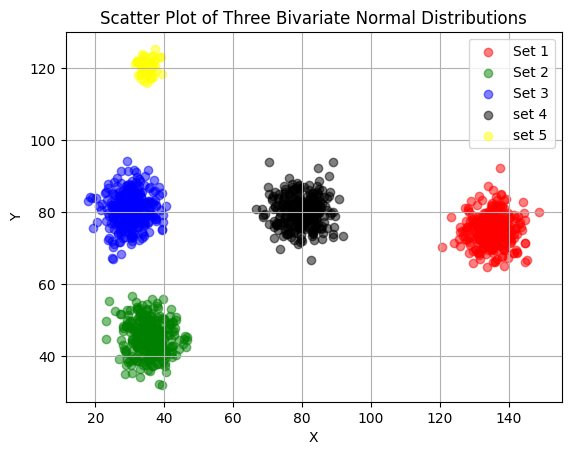

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

# Parameters for the three bivariate normal distributions
means = [[135, 75], [35, 45], [30, 80],[80,80],[35,120]]
covariances = [[[20, 0], [0, 20]], [[20, 0], [0, 20]],[[20, 0], [0, 20]],[[20, 0], [0, 20]], [[5, 0], [0, 5]]]
sizes = [300, 300,300,300, 50]

# Generate 2D data from the three bivariate normal distributions
data_sets = [np.random.multivariate_normal(means[i], covariances[i], sizes[i]) for i in range(5)]
# print(data_sets)
# Plot the scatter plot for each data set
colors = ['red', 'green', 'blue','black','yellow']
labels = ['Set 1', 'Set 2', 'Set 3','set 4','set 5']

for i in range(5):
    plt.scatter(data_sets[i][:, 0], data_sets[i][:, 1], alpha=0.5, color=colors[i], label=labels[i])

# Add labels and legend
plt.title('Scatter Plot of Three Bivariate Normal Distributions')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
X=np.concatenate(data_sets)
X

array([[137.22137322,  74.38166325],
       [137.8965512 ,  81.81119658],
       [133.95283427,  73.9529077 ],
       ...,
       [ 32.19036517, 121.81838208],
       [ 34.37621992, 119.37443725],
       [ 36.76732529, 120.76037781]])

Here, we will find roughly Kmean center by runing Kmeans algorithm (just 5 interation) to get rough idea of clusteres

In [ ]:
km1 =KMeans(n_clusters=5, max_iter=5)
y_predicted = km1.fit_predict(X)
B=np.array(km1.cluster_centers_)

print("Roughly kmean center :", B)

Roughly kmean center : [[ 30.1133969   80.48829282]
 [ 79.64091736  80.19837479]
 [134.95177112  74.92730885]
 [ 35.48065773  45.32686425]
 [ 35.06392598 120.32825757]]


Here, will get index of that points that having highest probability to select, in coreset generation

In [ ]:
import numpy as np
import pandas as pd

def aglo2(X, B, k):
    a = 16 * (np.log(k) + 2)
    Bi = [[] for _ in range(len(B))]
    X_dist = []
    X_min_bindx = []

    for i in range(len(X)):
        min_dist = 10000000000
        min_index = -1
        Xi = X[i]

        for j in range(len(B)):
            bj =B[j]
            dist = np.sum((Xi - bj) ** 2)

            if dist < min_dist:
                min_dist = dist
                min_index = j

        Bi[min_index].append(X[i])
        X_dist.append(min_dist)
        X_min_bindx.append(min_index)

    c_phi = 0

    for i in range(len(X)):
        c_phi += X_dist[i]

    S_x = []
    sigma_s = 0

    for i in range(len(X)):
        si = 0
        si += (a * X_dist[i]) / (c_phi)
        b_index = X_min_bindx[i]
        bi = B [b_index]
        temp_sum = 0

        for j in range(len(Bi[b_index])):
            temp_sum += np.sum((bi - Bi[b_index][j]) ** 2)

        si += (2 * a * temp_sum) / (len(Bi[b_index]) * c_phi)
        si += 4 * len(X) / len(Bi[b_index])
        S_x.append(si)
        sigma_s += si
    p_x=[]
    for i in range(len(X)):
        p_x.append(S_x[i] / sigma_s)
    np.random.shuffle(p_x)
    return np.argmax(p_x)
    # p_x = [S_x[i] / sigma_s for i in range(len(X))]
    # p_x_with_index = list(enumerate(p_x))  # Pair probabilities with their indices
    # np.random.shuffle(p_x_with_index)  # Shuffle the probabilities along with their indices
    # max_prob_index = max(p_x_with_index, key=lambda x: x[1])[0]  # Find the index of the max probability after shuffling
    # return max_prob_index

In [ ]:
def k_closest_points(points, k, i):
    distances = []
    for point in points:
        distance = np.sqrt(np.sum((point -  points[i])** 2))
        distances.append((distance, point))
    return sorted(range(len(distances)), key=lambda i: distances[i])[:k]

import numpy as np
import random

# def privet_center(points, E):
#     center = []
#     for x in range(points.shape[1]):
#         co_ordinates = [i[x] for i in points]
#         min_v = min(co_ordinates)
#         max_v = max(co_ordinates)
#         s = np.sum(co_ordinates) - len(co_ordinates) * ((min_v + max_v) / 2) + random.laplace(scale=(max_v - min_v) / E)
#         c = len(co_ordinates) + random.laplace(scale=2 / E)
#         if c <= 1:
#             center.append((min_v + max_v) / 2)
#         else:
#             center.append((s / c) + ((min_v + max_v) / 2))
#     return np.array(center)




In this function, we will select most importenet points, one by one and we will delet t nearet point to that selected point, and we will add that selected point in coreset.

In [ ]:
import math
# print(point_got)
def Private_k_Mean(P,k, B, t):
  D=[]
  n=len(P)
  # d=2
  # Ei = (3 * E) / (8*k * math.log(n))
  # thitai = (3 * thita) / (8*k * math.log(n))
  # bitai = (3 * bita) / (8*k * math.log(n))
  # t =  (k * math.sqrt(d) / Ei *math.log(1 / bitai) *math.log((n * d) / (bitai * Ei * thitai)) *math.sqrt(math.log(1 / (bitai * thitai))) * 9**(math.log(2 * len(P) * math.sqrt(d))))

  while len(P)>t :
    # n=len(P)
    # print(len(P),t)
    # delta=(1/Ei)*(math.log(1/bitai))*math.log((n)/(bitai*Ei*thitai))*(9**(math.log(2 * len(P) * math.sqrt(d))))
    # w=((3*n)//(8*k))
    # if(w==0):
    #   return D
    # r_opt=Good_r(P,t,bitai, Ei, thitai)
    c_index=aglo2(P, B, k)
    c=P[c_index]
    delet_index=k_closest_points(P,t,c_index)
    P=np.delete(P,delet_index, axis=0)
    # c=np.append(c,w)
    D.append(c)

  return D



In [ ]:
def cost(X,centers):
  sum=0
  for i in range(len(X)):
    point1=X[i]
    cost_i=100000
    for j in range(len(centers)):
      point2=centers[j]
      if(np.sum((point1 - point2)**2)<cost_i):
        cost_i=np.sum((point1 - point2)**2)
    sum+=cost_i
  return sum

In [ ]:
corset_error=[]
random_error=[]
k=5
km_full =KMeans(n_clusters=5)
y_full = km_full.fit_predict(X)
cost_org=km_full.inertia_
for t in [4,8,12,16,20,24,28]:
  km_sub=KMeans(n_clusters=5)
  km_sub.fit_predict(Private_k_Mean(X, k,B,t))
  sub_center=km_sub.cluster_centers_
  cost_by_sub_center=cost(X,sub_center)
  error=(cost_by_sub_center- cost_org)/cost_org * 100
  corset_error.append(error)
  km_sub=KMeans(n_clusters=5)
  
  km_sub.fit_predict(X[np.random.choice(len(X), len(X)//t, replace=False)])
  sub_center=km_sub.cluster_centers_
  cost_by_sub_center=cost(X,sub_center)
  error=(cost_by_sub_center- cost_org)/cost_org * 100
  random_error.append(error)


Here we will check accuracy rate for different t.

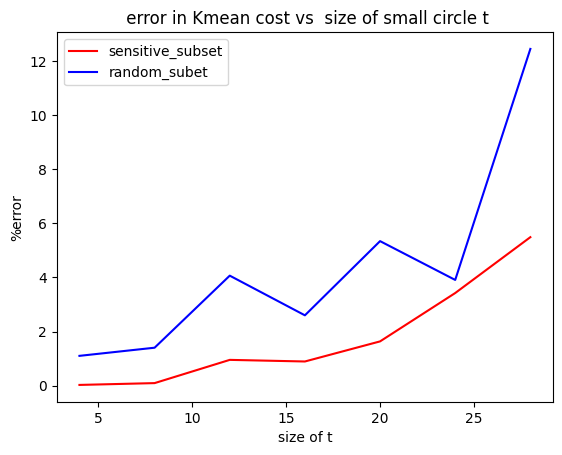

In [ ]:
import matplotlib.pyplot as plt

# Example data
x1 = corset_error

x3 =random_error
y = [4,8,12,16,20,24,28]

# Plot x1 in red
plt.plot(y, x1, color='red', label='sensitive_subset')

# # Plot x2 in green
# plt.plot(y, x2, color='green', label='subset_using_dist')
# Plot x2 in green
plt.plot(y, x3, color='blue', label='random_subet')

# Customize the plot
plt.xlabel('size of t')
plt.ylabel('%error')
plt.title(' error in Kmean cost vs  size of small circle t')
plt.legend()

# Show the plot
plt.show()

In [ ]:
point_got=np.array(Private_k_Mean(X,5, B,10))

In [ ]:
print(point_got)

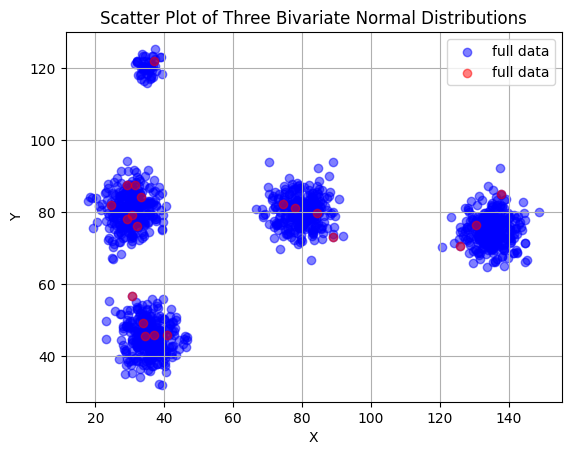

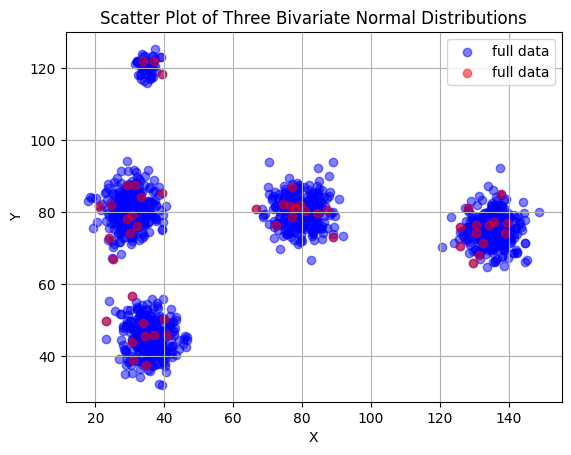

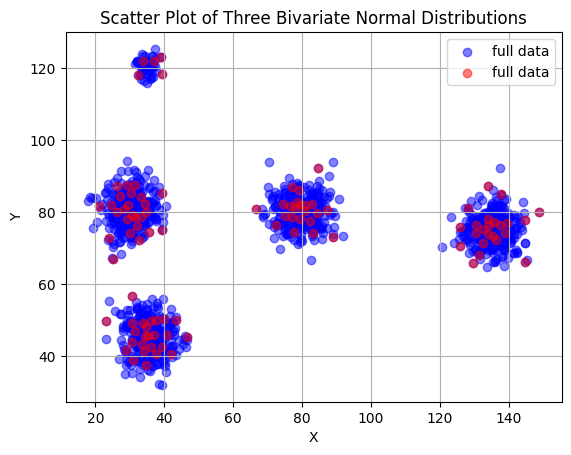

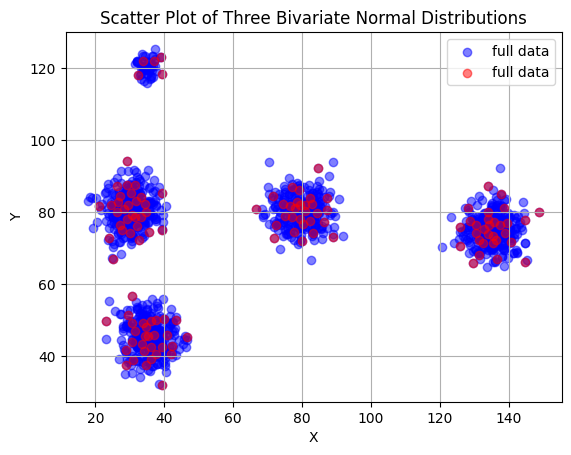

In [ ]:
plt.scatter(X[:, 0], X[:, 1], alpha=0.5, color='blue', label='full data')

plt.scatter(point_got[:20, 0], point_got[:20, 1], alpha=0.5, color='red', label='full data')

# Add labels and legend
plt.title('Scatter Plot of Three Bivariate Normal Distributions')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.grid(True)
plt.show()

plt.scatter(X[:, 0], X[:, 1], alpha=0.5, color='blue', label='full data')

plt.scatter(point_got[:50, 0], point_got[:50, 1], alpha=0.5, color='red', label='full data')


# Add labels and legend
plt.title('Scatter Plot of Three Bivariate Normal Distributions')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.grid(True)
plt.show()


plt.scatter(X[:, 0], X[:, 1], alpha=0.5, color='blue', label='full data')

plt.scatter(point_got[:100, 0], point_got[:100, 1], alpha=0.5, color='red', label='full data')


# Add labels and legend
plt.title('Scatter Plot of Three Bivariate Normal Distributions')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.grid(True)
plt.show()


plt.scatter(X[:, 0], X[:, 1], alpha=0.5, color='blue', label='full data')

plt.scatter(point_got[:, 0], point_got[:, 1], alpha=0.5, color='red', label='full data')


# Add labels and legend
plt.title('Scatter Plot of Three Bivariate Normal Distributions')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
corset_error=[]
random_error=[]
k=5
km_full =KMeans(n_clusters=5)
y_full = km_full.fit_predict(X)
cost_org=km_full.inertia_
for l in [40,50,70,95,120,124]:
  km_sub=KMeans(n_clusters=5)
  km_sub.fit_predict(point_got[:l,:])
  sub_center=km_sub.cluster_centers_
  cost_by_sub_center=cost(X,sub_center)
  error=(cost_by_sub_center- cost_org)/cost_org * 100
  corset_error.append(error)
  km_sub=KMeans(n_clusters=5)
  km_sub.fit_predict(X[np.random.choice(len(X), l, replace=False)])
  sub_center=km_sub.cluster_centers_
  cost_by_sub_center=cost(X,sub_center)
  error=(cost_by_sub_center- cost_org)/cost_org * 100
  random_error.append(error)

Here we will check accuracy for different coreset size.

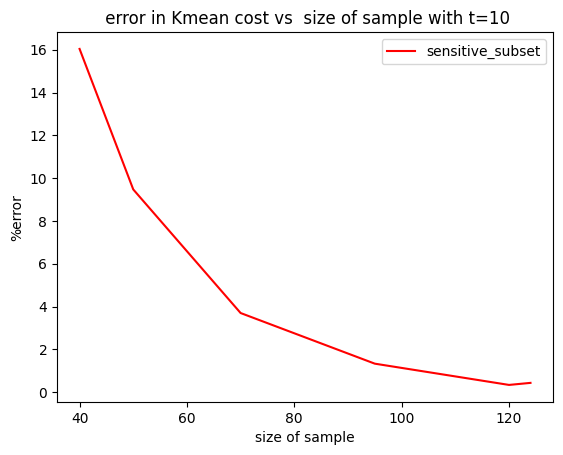

In [ ]:
import matplotlib.pyplot as plt

# Example data
x = corset_error


y = [40,50,70,95,120,124]

# Plot x1 in red
plt.plot(y, x, color='red', label='sensitive_subset')


# Customize the plot
plt.xlabel('size of sample')
plt.ylabel('%error')
plt.title(' error in Kmean cost vs  size of sample with t=10')
plt.legend()

# Show the plot
plt.show()